In [1]:
from itertools import combinations
import random

import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) # topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))

## Data preprocessing

In [3]:
ratings = pd.read_csv('ml-1m/ratings.dat', header=None, sep='::', 
                      encoding='latin-1', engine='python', 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])
users = pd.read_csv('ml-1m/users.dat', header=None, sep='::',
                    encoding='latin-1', engine='python',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
movies = pd.read_csv('ml-1m/movies.dat', header=None, sep='::',
                     encoding='latin-1', engine='python',
                     names=['movie_id', 'title', 'genres'])

In [4]:
ratings['user_id'] = ratings['user_id'] - 1
ratings['movie_id'] = ratings['movie_id'] - 1
users['user_id'] = users['user_id'] - 1
movies['movie_id'] = movies['movie_id'] - 1

In [5]:
user_n = ratings['user_id'].nunique()
item_n = movies['movie_id'].nunique()

In [6]:
item_id_to_iid = {movies['movie_id'][i]:i for i in movies.index}
item_iid_to_id = {i:movies['movie_id'][i] for i in movies.index}

## Extract movie feature vectors from genre information

### Tokenize genre information

In [7]:
tf = TfidfVectorizer(analyzer=lambda x: (g for g in x.split('|')))

In [8]:
analyzer = tf.build_analyzer()

In [9]:
[token for token in analyzer('Action|Crime|Drama')]

['Action', 'Crime', 'Drama']

### Get the weighted frequency of each token and form the feature vector of the movie

In [10]:
X_tfidf = tf.fit_transform(movies['genres'])
X_tfidf.shape

(3883, 18)

### LDA

In [11]:
lda = LatentDirichletAllocation(n_components=5) # 5 hidden topics

In [12]:
X_lda = lda.fit_transform(X_tfidf)

In [13]:
X_lda.shape

(3883, 5)

&uarr; Transformed each 18-d feature vector (old genres) into a 5-d vector (new genres). Use this new matrix for recommendation.

In [14]:
lda.components_.shape

(5, 18)

&uarr; The weights of each old genre in every new genre.

&darr; Print out the composition of new genres.

In [15]:
genres = tf.get_feature_names_out()

In [16]:
for i, weights in enumerate(lda.components_):
    zipped = zip(genres, weights)
    top_genres_key = sorted(zipped, key = lambda t: t[1], reverse=True)[:4]
    top_genres_list = list(dict(top_genres_key).keys())
    print("Topic " + str(i) + ": ", top_genres_list)

Topic 0:  ['Crime', 'Musical', 'Mystery', 'Thriller']
Topic 1:  ['Comedy', 'Sci-Fi', 'Western', 'Action']
Topic 2:  ['Thriller', 'Adventure', "Children's", 'Action']
Topic 3:  ['Drama', 'Documentary', 'Romance', 'War']
Topic 4:  ['Romance', 'Horror', 'Action', 'Comedy']


## Content based filtering using regular genres

In [11]:
train_df, test_df = train_test_split(ratings, test_size=0.2)

In [12]:
def df_to_mat(df):
    """
    Convert DataFrame to sparse matrix.

    Arg:
        df: DataFrame, ratings dataframe with user_id, movie_id and rating

    Return:
        mat: scipy.sparse.csr_matrix, sparse ratings matrix with rows being items and cols being users
    """
    
    mat = sparse.lil_matrix((item_n, user_n))
    for _, row in df.iterrows():
        user_id = int(row[0])
        item_id = int(row[1])
        item_iid = item_id_to_iid[item_id]
        rating = row[2]
        mat[item_iid, user_id] = rating
    
    return mat 

In [13]:
item_user_mat = df_to_mat(train_df)
item_user_mat.shape

(3883, 6040)

In [20]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, 
                       n_jobs=-1)
knn.fit(X_tfidf)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [21]:
def cb_recommend(user_id, topk, knn, X):

    user_ratings = item_user_mat[:, user_id]
    rated_before = np.nonzero(user_ratings)[0]
    sorted_rated_before = rated_before[
        np.argsort(user_ratings[rated_before].toarray().squeeze())][::-1]
    
    if sorted_rated_before.size > 0:

        raw_recommends = {}
        for item_iid in sorted_rated_before:
            distances, indices = knn.kneighbors(X[item_iid], 
                                                n_neighbors=topk+1)
            sorted_pairs = sorted(list(zip(indices.squeeze().tolist(),
                                           distances.squeeze().tolist())),
                                  key=lambda x: x[1])
            raw_recommends[item_iid] = sorted_pairs 
        
        top_items = []
        pos = 0
        while True:
            for item_iid in sorted_rated_before:
                next_neighbor_iid = raw_recommends[item_iid][pos][0]
                if next_neighbor_iid not in rated_before:
                    top_items.append(item_iid_to_id[next_neighbor_iid])
                if len(top_items) > topk - 1:
                    return (user_id, np.array(top_items))
            
            pos += 1
    else:

        top_items = list(map(lambda x: item_iid_to_id[x], 
                             random.sample(list(range(0, item_n)), topk)))
        return (user_id, np.array(top_items))

### Evaluate regular content based filering on 100F and 100M, 20 runs

In [14]:
test_mat = df_to_mat(test_df)

In [15]:
f_users = users[users['gender'] == 'F']
m_users=  users[users['gender'] == 'M']

In [24]:
def sample_evaluate(test_user_ids, knn, X):

    r = []
    p = []
    
    for user_id in test_user_ids:
        test_items_iids = list(np.argwhere(test_mat[:, user_id] >= 4)[:, 0])
        test_items = list(map(lambda x: item_iid_to_id[x], test_items_iids))

        if len(test_items) > 0:
            top_items = list(cb_recommend(user_id, 10, knn, X)[1])

            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)

            r.append(recall)
            p.append(precision)
    
    return (np.average(r), np.average(p))

In [25]:
all_f_cb_r = []
all_f_cb_p = []

all_m_cb_r = []
all_m_cb_p = []

epochs = 10

for epoch in range(epochs):
    test_f_user_ids = f_users.sample(100)['user_id'].to_numpy()
    test_m_user_ids = m_users.sample(100)['user_id'].to_numpy()

    # evaluation of content-based filtering on female users
    f_cb_r, f_cb_p = sample_evaluate(test_f_user_ids, knn, X_tfidf)
    all_f_cb_r.append(f_cb_r)
    all_f_cb_p.append(f_cb_p)

    # evaluation of content-based filtering on male users
    m_cb_r, m_cb_p = sample_evaluate(test_m_user_ids, knn, X_tfidf)
    all_m_cb_r.append(m_cb_r)
    all_m_cb_p.append(m_cb_p)


In [26]:
print(f'Female average recall over {epochs} runs: {np.average(all_f_cb_r)}')
print(f'Female average precision over {epochs} runs: {np.average(all_f_cb_p)}')
print(f'Male average recall over {epochs} runs: {np.average(all_m_cb_r)}')
print(f'Male average precision over {epochs} runs: {np.average(all_m_cb_p)}')

Female average recall over 10 runs: 0.006171493886449818
Female average precision over 10 runs: 0.00858364309041001
Male average recall over 10 runs: 0.0080106183259368
Male average precision over 10 runs: 0.012645660688517833


## Content based filtering with LDA

In [16]:
def cb_recommend(user_id, topk, knn, X):

    user_ratings = item_user_mat[:, user_id]
    rated_before = np.nonzero(user_ratings)[0]
    sorted_rated_before = rated_before[
        np.argsort(user_ratings[rated_before].toarray().squeeze())][::-1]
    
    if sorted_rated_before.size > 0:

        raw_recommends = {}
        for item_iid in sorted_rated_before:
            distances, indices = knn.kneighbors(X[item_iid], 
                                                n_neighbors=topk+1)
            sorted_pairs = sorted(list(zip(indices.squeeze().tolist(),
                                           distances.squeeze().tolist())),
                                  key=lambda x: x[1])
            raw_recommends[item_iid] = sorted_pairs 
        
        top_items = []
        pos = 0
        while True:
            for item_iid in sorted_rated_before:
                next_neighbor_iid = raw_recommends[item_iid][pos][0]
                if next_neighbor_iid not in rated_before:
                    top_items.append(item_iid_to_id[next_neighbor_iid])
                if len(top_items) > topk - 1:
                    return (user_id, np.array(top_items))
            
            pos += 1
    else:

        top_items = list(map(lambda x: item_iid_to_id[x], 
                             random.sample(list(range(0, item_n)), topk)))
        return (user_id, np.array(top_items))

In [17]:
def sample_evaluate(test_user_ids, knn, X):

    r = []
    p = []
    f1 = []
    
    for user_id in test_user_ids:
        test_items_iids = list(np.argwhere(test_mat[:, user_id] >= 4)[:, 0])
        test_items = list(map(lambda x: item_iid_to_id[x], test_items_iids))

        if len(test_items) > 0:
            top_items = list(cb_recommend(user_id, 10, knn, X)[1])

            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)

            r.append(recall)
            p.append(precision)
            
            if precision + recall != 0:
                f1.append(2 * (precision * recall) / (precision + recall))
    
    return (np.average(r), np.average(p), np.average(f1))

In [45]:
f_lda_r_list = []
f_lda_p_list = []
m_lda_r_list = []
m_lda_p_list = []
f_lda_f1_list = []
m_lda_f1_list = []

f_lda_r_err_list = []
f_lda_p_err_list = []
m_lda_r_err_list = []
m_lda_p_err_list = []
f_lda_f1_err_list = []
m_lda_f1_err_list = []

for n in range(5,20):
    lda = LatentDirichletAllocation(n_components=n)
    X_lda = lda.fit_transform(X_tfidf)
    X_lda = sparse.csr_matrix(X_lda)
    knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=10, 
                       n_jobs=-1)
    knn.fit(X_lda)

    all_f_lda_r = []
    all_f_lda_p = []
    all_f_lda_f1 = []

    all_m_lda_r = []
    all_m_lda_p = []
    all_m_lda_f1 = []
    
    epochs = 50
    for epoch in range(epochs):
        test_f_user_ids = f_users.sample(100)['user_id'].to_numpy()
        test_m_user_ids = m_users.sample(100)['user_id'].to_numpy()

        # evaluation of lda content-based filtering on female users
        f_lda_r, f_lda_p, f_lda_f1 = sample_evaluate(test_f_user_ids, knn, X_lda)
        all_f_lda_r.append(f_lda_r)
        all_f_lda_p.append(f_lda_p)
        all_f_lda_f1.append(f_lda_f1)

        # evaluation of lda content-based filtering on male users
        m_lda_r, m_lda_p, m_lda_f1 = sample_evaluate(test_m_user_ids, knn, X_lda)
        all_m_lda_r.append(m_lda_r)
        all_m_lda_p.append(m_lda_p)
        all_m_lda_f1.append(m_lda_f1)
    
    f_lda_r_list.append(np.average(all_f_lda_r))
    f_lda_p_list.append(np.average(all_f_lda_p))
    f_lda_f1_list.append(np.average(all_f_lda_f1))
    m_lda_r_list.append(np.average(all_m_lda_r))
    m_lda_p_list.append(np.average(all_m_lda_p))
    m_lda_f1_list.append(np.average(all_m_lda_f1))

    f_lda_r_err_list.append(np.std(all_f_lda_r))
    f_lda_p_err_list.append(np.std(all_f_lda_p))
    f_lda_f1_err_list.append(np.std(all_f_lda_f1))
    m_lda_r_err_list.append(np.std(all_m_lda_r))
    m_lda_p_err_list.append(np.std(all_m_lda_p))
    m_lda_f1_err_list.append(np.std(all_m_lda_f1))

In [46]:
len(m_lda_r_list)

15

In [84]:
print(m_lda_p_list)

[0.015927272727272727, 0.019219253762110904, 0.019599670171098746, 0.012768872397443828, 0.012135160143407566, 0.014295192616253, 0.016181282209853636, 0.008695238095238096]


ValueError: 'x' and 'y' must have the same size

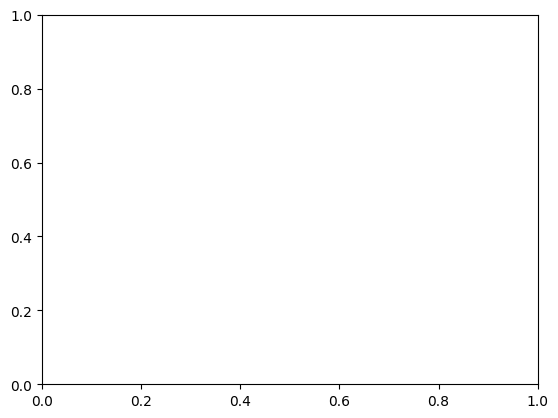

In [47]:
fig = plt.figure()
plt.errorbar(np.arange(3,11), m_lda_r_list, yerr=m_lda_r_err_list, capsize=5, c='b', label='Male')
# plt.errorbar(np.arange(3,11), m_lda_r_list, yerr=m_lda_r_err_list, capsize=5, c='b', label='Male')
plt.xticks(np.arange(3,11))
plt.xlim([3,10])
plt.ylim([0,0.03])
plt.xlabel('Number of latent genres')
plt.ylabel('Recall')
plt.show()

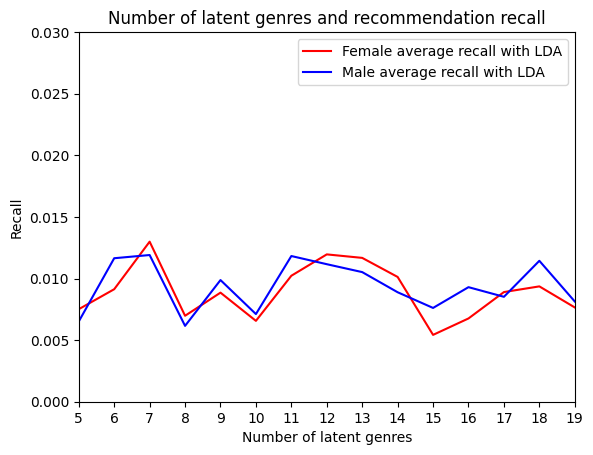

In [49]:
fig, ax = plt.subplots()
ax.plot(np.arange(5,20), f_lda_r_list, c='r', label='Female average recall with LDA')
ax.plot(np.arange(5,20), m_lda_r_list, c='b', label='Male average recall with LDA')
# ax.hlines(y=np.average(all_f_cb_r), xmin=5, xmax=19, color='r', linestyle='--', label='Female average recall without LDA')
# ax.hlines(y=np.average(all_m_cb_r), xmin=5, xmax=19, color='b', linestyle='--', label='Male average recall without LDA')
ax.set_xticks(np.arange(5,20))
legend = ax.legend(loc='upper right')
ax.set_xlim([5,19])
ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('Recall')
plt.title('Number of latent genres and recommendation recall')
plt.show()

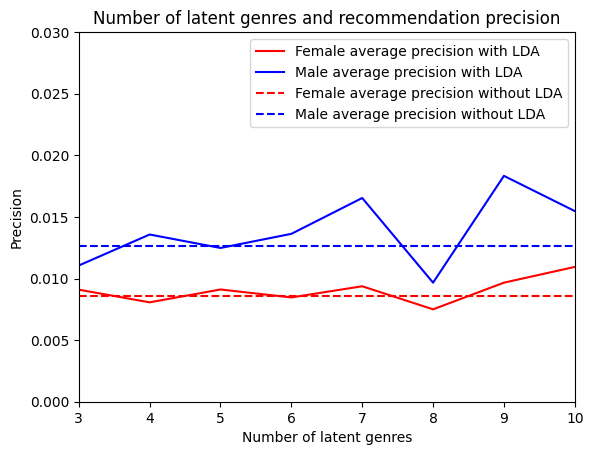

In [96]:
fig, ax = plt.subplots()
ax.plot(np.arange(3,11), f_lda_p_list, c='r', label='Female average precision with LDA')
ax.plot(np.arange(3,11), m_lda_p_list, c='b', label='Male average precision with LDA')
ax.hlines(y=np.average(all_f_cb_p), xmin=3, xmax=10, color='r', linestyle='--', label='Female average precision without LDA')
ax.hlines(y=np.average(all_m_cb_p), xmin=3, xmax=10, color='b', linestyle='--', label='Male average precision without LDA')
ax.set_xticks(np.arange(3,11))
legend = ax.legend(loc='upper right')
ax.set_xlim([3,10])
ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('Precision')
plt.title('Number of latent genres and recommendation precision')
plt.show()

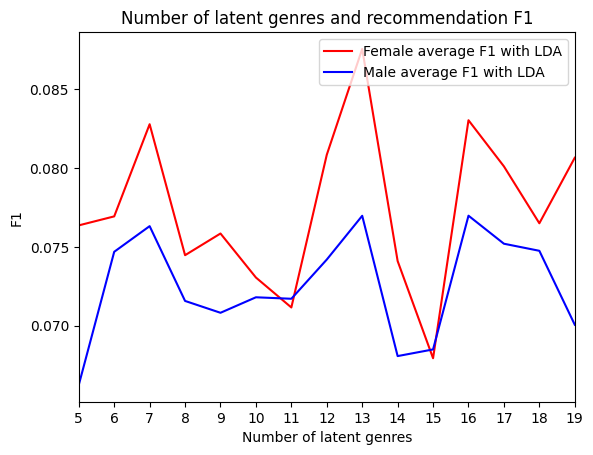

In [54]:
fig, ax = plt.subplots()
ax.plot(np.arange(5,20), f_lda_f1_list, c='r', label='Female average F1 with LDA')
ax.plot(np.arange(5,20), m_lda_f1_list, c='b', label='Male average F1 with LDA')
# ax.hlines(y=np.average(all_f_cb_p), xmin=3, xmax=10, color='r', linestyle='--', label='Female average precision without LDA')
# ax.hlines(y=np.average(all_m_cb_p), xmin=3, xmax=10, color='b', linestyle='--', label='Male average precision without LDA')
ax.set_xticks(np.arange(5,20))
legend = ax.legend(loc='upper right')
ax.set_xlim([5,19])
# ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('F1')
plt.title('Number of latent genres and recommendation F1')
plt.show()

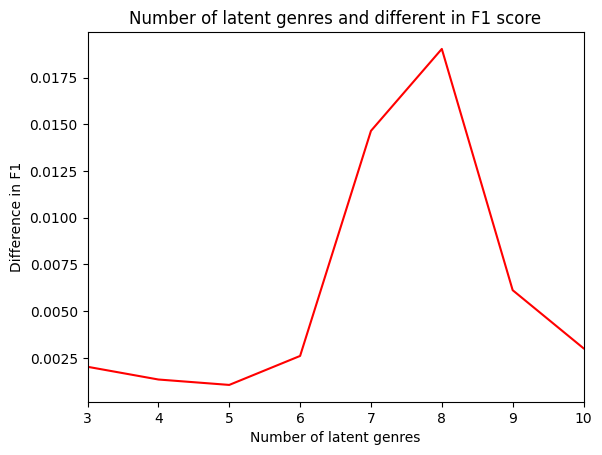

In [100]:
fig, ax = plt.subplots()
ax.plot(np.arange(3,11), np.abs(np.array(m_lda_f1_list) - np.array(f_lda_f1_list)), c='r', label='Difference in average F1 score with LDA')

# ax.hlines(y=np.average(all_f_cb_p), xmin=3, xmax=10, color='r', linestyle='--', label='Female average precision without LDA')

ax.set_xticks(np.arange(3,11))
# legend = ax.legend(loc='upper right')
ax.set_xlim([3,10])
# ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('Difference in F1')
plt.title('Number of latent genres and different in F1 score')
plt.show()

In [66]:
f_lda_r_ary = np.array(f_lda_r_list)
f_lda_p_ary = np.array(f_lda_p_list)
m_lda_r_ary = np.array(m_lda_r_list)
m_lda_p_ary = np.array(m_lda_p_list)
f_lda_f1_ary = np.array(f_lda_f1_list)
m_lda_f1_ary = np.array(m_lda_f1_list)

f_lda_r_err_ary = np.array(f_lda_r_err_list)
f_lda_p_err_ary = np.array(f_lda_p_err_list)
m_lda_r_err_ary = np.array(m_lda_r_err_list)
m_lda_p_err_ary = np.array(m_lda_p_err_list)
f_lda_f1_err_ary = np.array(f_lda_f1_err_list)
m_lda_f1_err_ary = np.array(m_lda_f1_err_list)

In [67]:
np.save('results/f_lda_r_ary.npy', f_lda_r_ary)
np.save('results/f_lda_p_ary.npy', f_lda_p_ary)
np.save('results/m_lda_r_ary.npy', m_lda_r_ary)
np.save('results/m_lda_p_ary.npy', m_lda_p_ary)
np.save('results/f_lda_f1_ary.npy', f_lda_f1_ary)
np.save('results/m_lda_f1_ary.npy', m_lda_f1_ary)

np.save('results/f_lda_r_err_ary.npy', f_lda_r_err_ary)
np.save('results/f_lda_p_err_ary.npy', f_lda_p_err_ary)
np.save('results/m_lda_r_err_ary.npy', m_lda_r_err_ary)
np.save('results/m_lda_p_err_ary.npy', m_lda_p_err_ary)
np.save('results/f_lda_f1_err_ary.npy', f_lda_f1_err_ary)
np.save('results/m_lda_f1_err_ary.npy', m_lda_f1_err_ary)

In [68]:
np.load('results/f_lda_r_ary.npy')

array([0.00751074, 0.00913264, 0.01299128, 0.00697665, 0.00885389,
       0.0065641 , 0.01022581, 0.01195899, 0.01167519, 0.01012732,
       0.0054256 , 0.00675923, 0.00890046, 0.00936212, 0.00765246])

In [69]:
head_f_lda_r_list = []
head_f_lda_p_list = []
head_m_lda_r_list = []
head_m_lda_p_list = []
head_f_lda_f1_list = []
head_m_lda_f1_list = []

head_f_lda_r_err_list = []
head_f_lda_p_err_list = []
head_m_lda_r_err_list = []
head_m_lda_p_err_list = []
head_f_lda_f1_err_list = []
head_m_lda_f1_err_list = []

for n in range(3,5):
    lda = LatentDirichletAllocation(n_components=n)
    X_lda = lda.fit_transform(X_tfidf)
    X_lda = sparse.csr_matrix(X_lda)
    knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=10, 
                       n_jobs=-1)
    knn.fit(X_lda)

    all_f_lda_r = []
    all_f_lda_p = []
    all_f_lda_f1 = []

    all_m_lda_r = []
    all_m_lda_p = []
    all_m_lda_f1 = []
    
    epochs = 50
    for epoch in range(epochs):
        test_f_user_ids = f_users.sample(100)['user_id'].to_numpy()
        test_m_user_ids = m_users.sample(100)['user_id'].to_numpy()

        # evaluation of lda content-based filtering on female users
        f_lda_r, f_lda_p, f_lda_f1 = sample_evaluate(test_f_user_ids, knn, X_lda)
        all_f_lda_r.append(f_lda_r)
        all_f_lda_p.append(f_lda_p)
        all_f_lda_f1.append(f_lda_f1)

        # evaluation of lda content-based filtering on male users
        m_lda_r, m_lda_p, m_lda_f1 = sample_evaluate(test_m_user_ids, knn, X_lda)
        all_m_lda_r.append(m_lda_r)
        all_m_lda_p.append(m_lda_p)
        all_m_lda_f1.append(m_lda_f1)
    
    head_f_lda_r_list.append(np.average(all_f_lda_r))
    head_f_lda_p_list.append(np.average(all_f_lda_p))
    head_f_lda_f1_list.append(np.average(all_f_lda_f1))
    head_m_lda_r_list.append(np.average(all_m_lda_r))
    head_m_lda_p_list.append(np.average(all_m_lda_p))
    head_m_lda_f1_list.append(np.average(all_m_lda_f1))

    head_f_lda_r_err_list.append(np.std(all_f_lda_r))
    head_f_lda_p_err_list.append(np.std(all_f_lda_p))
    head_f_lda_f1_err_list.append(np.std(all_f_lda_f1))
    head_m_lda_r_err_list.append(np.std(all_m_lda_r))
    head_m_lda_p_err_list.append(np.std(all_m_lda_p))
    head_m_lda_f1_err_list.append(np.std(all_m_lda_f1))

In [70]:
head_f_lda_r_ary = np.array(head_f_lda_r_list)
head_f_lda_p_ary = np.array(head_f_lda_p_list)
head_m_lda_r_ary = np.array(head_m_lda_r_list)
head_m_lda_p_ary = np.array(head_m_lda_p_list)
head_f_lda_f1_ary = np.array(head_f_lda_f1_list)
head_m_lda_f1_ary = np.array(head_m_lda_f1_list)

head_f_lda_r_err_ary = np.array(head_f_lda_r_err_list)
head_f_lda_p_err_ary = np.array(head_f_lda_p_err_list)
head_m_lda_r_err_ary = np.array(head_m_lda_r_err_list)
head_m_lda_p_err_ary = np.array(head_m_lda_p_err_list)
head_f_lda_f1_err_ary = np.array(head_f_lda_f1_err_list)
head_m_lda_f1_err_ary = np.array(head_m_lda_f1_err_list)

In [71]:
np.save('results/head_f_lda_r_ary.npy', head_f_lda_r_ary)
np.save('results/head_f_lda_p_ary.npy', head_f_lda_p_ary)
np.save('results/head_m_lda_r_ary.npy', head_m_lda_r_ary)
np.save('results/head_m_lda_p_ary.npy', head_m_lda_p_ary)
np.save('results/head_f_lda_f1_ary.npy', head_f_lda_f1_ary)
np.save('results/head_m_lda_f1_ary.npy', head_m_lda_f1_ary)

np.save('results/head_f_lda_r_err_ary.npy', head_f_lda_r_err_ary)
np.save('results/head_f_lda_p_err_ary.npy', head_f_lda_p_err_ary)
np.save('results/head_m_lda_r_err_ary.npy', head_m_lda_r_err_ary)
np.save('results/head_m_lda_p_err_ary.npy', head_m_lda_p_err_ary)
np.save('results/head_f_lda_f1_err_ary.npy', head_f_lda_f1_err_ary)
np.save('results/head_m_lda_f1_err_ary.npy', head_m_lda_f1_err_ary)

In [73]:
tail_f_lda_r_list = []
tail_f_lda_p_list = []
tail_m_lda_r_list = []
tail_m_lda_p_list = []
tail_f_lda_f1_list = []
tail_m_lda_f1_list = []

tail_f_lda_r_err_list = []
tail_f_lda_p_err_list = []
tail_m_lda_r_err_list = []
tail_m_lda_p_err_list = []
tail_f_lda_f1_err_list = []
tail_m_lda_f1_err_list = []

for n in range(20,21):
    lda = LatentDirichletAllocation(n_components=n)
    X_lda = lda.fit_transform(X_tfidf)
    X_lda = sparse.csr_matrix(X_lda)
    knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=10, 
                       n_jobs=-1)
    knn.fit(X_lda)

    all_f_lda_r = []
    all_f_lda_p = []
    all_f_lda_f1 = []

    all_m_lda_r = []
    all_m_lda_p = []
    all_m_lda_f1 = []
    
    epochs = 50
    for epoch in range(epochs):
        test_f_user_ids = f_users.sample(100)['user_id'].to_numpy()
        test_m_user_ids = m_users.sample(100)['user_id'].to_numpy()

        # evaluation of lda content-based filtering on female users
        f_lda_r, f_lda_p, f_lda_f1 = sample_evaluate(test_f_user_ids, knn, X_lda)
        all_f_lda_r.append(f_lda_r)
        all_f_lda_p.append(f_lda_p)
        all_f_lda_f1.append(f_lda_f1)

        # evaluation of lda content-based filtering on male users
        m_lda_r, m_lda_p, m_lda_f1 = sample_evaluate(test_m_user_ids, knn, X_lda)
        all_m_lda_r.append(m_lda_r)
        all_m_lda_p.append(m_lda_p)
        all_m_lda_f1.append(m_lda_f1)
    
    tail_f_lda_r_list.append(np.average(all_f_lda_r))
    tail_f_lda_p_list.append(np.average(all_f_lda_p))
    tail_f_lda_f1_list.append(np.average(all_f_lda_f1))
    tail_m_lda_r_list.append(np.average(all_m_lda_r))
    tail_m_lda_p_list.append(np.average(all_m_lda_p))
    tail_m_lda_f1_list.append(np.average(all_m_lda_f1))

    tail_f_lda_r_err_list.append(np.std(all_f_lda_r))
    tail_f_lda_p_err_list.append(np.std(all_f_lda_p))
    tail_f_lda_f1_err_list.append(np.std(all_f_lda_f1))
    tail_m_lda_r_err_list.append(np.std(all_m_lda_r))
    tail_m_lda_p_err_list.append(np.std(all_m_lda_p))
    tail_m_lda_f1_err_list.append(np.std(all_m_lda_f1))

In [74]:
tail_f_lda_r_ary = np.array(tail_f_lda_r_list)
tail_f_lda_p_ary = np.array(tail_f_lda_p_list)
tail_m_lda_r_ary = np.array(tail_m_lda_r_list)
tail_m_lda_p_ary = np.array(tail_m_lda_p_list)
tail_f_lda_f1_ary = np.array(tail_f_lda_f1_list)
tail_m_lda_f1_ary = np.array(tail_m_lda_f1_list)

tail_f_lda_r_err_ary = np.array(tail_f_lda_r_err_list)
tail_f_lda_p_err_ary = np.array(tail_f_lda_p_err_list)
tail_m_lda_r_err_ary = np.array(tail_m_lda_r_err_list)
tail_m_lda_p_err_ary = np.array(tail_m_lda_p_err_list)
tail_f_lda_f1_err_ary = np.array(tail_f_lda_f1_err_list)
tail_m_lda_f1_err_ary = np.array(tail_m_lda_f1_err_list)

In [75]:
np.save('results/tail_f_lda_r_ary.npy', tail_f_lda_r_ary)
np.save('results/tail_f_lda_p_ary.npy', tail_f_lda_p_ary)
np.save('results/tail_m_lda_r_ary.npy', tail_m_lda_r_ary)
np.save('results/tail_m_lda_p_ary.npy', tail_m_lda_p_ary)
np.save('results/tail_f_lda_f1_ary.npy', tail_f_lda_f1_ary)
np.save('results/tail_m_lda_f1_ary.npy', tail_m_lda_f1_ary)

np.save('results/tail_f_lda_r_err_ary.npy', tail_f_lda_r_err_ary)
np.save('results/tail_f_lda_p_err_ary.npy', tail_f_lda_p_err_ary)
np.save('results/tail_m_lda_r_err_ary.npy', tail_m_lda_r_err_ary)
np.save('results/tail_m_lda_p_err_ary.npy', tail_m_lda_p_err_ary)
np.save('results/tail_f_lda_f1_err_ary.npy', tail_f_lda_f1_err_ary)
np.save('results/tail_m_lda_f1_err_ary.npy', tail_m_lda_f1_err_ary)

In [87]:
whole_f_lda_f1_ary = np.concatenate((head_f_lda_f1_ary, f_lda_f1_ary, tail_f_lda_f1_ary))
whole_m_lda_f1_ary = np.concatenate((head_m_lda_f1_ary, m_lda_f1_ary, tail_m_lda_f1_ary))

whole_f_lda_r_ary = np.concatenate((head_f_lda_r_ary, f_lda_r_ary, tail_f_lda_r_ary))
whole_m_lda_r_ary = np.concatenate((head_m_lda_r_ary, m_lda_r_ary, tail_m_lda_r_ary))

whole_f_lda_p_ary = np.concatenate((head_f_lda_p_ary, f_lda_p_ary, tail_f_lda_p_ary))
whole_m_lda_p_ary = np.concatenate((head_m_lda_p_ary, m_lda_p_ary, tail_m_lda_p_ary))

whole_f_lda_f1_err_ary = np.concatenate((head_f_lda_f1_err_ary, f_lda_f1_err_ary, tail_f_lda_f1_err_ary))
whole_m_lda_f1_err_ary = np.concatenate((head_m_lda_f1_err_ary, m_lda_f1_err_ary, tail_m_lda_f1_err_ary))

whole_f_lda_r_err_ary = np.concatenate((head_f_lda_r_err_ary, f_lda_r_err_ary, tail_f_lda_r_err_ary))
whole_m_lda_r_err_ary = np.concatenate((head_m_lda_r_err_ary, m_lda_r_err_ary, tail_m_lda_r_err_ary))

whole_f_lda_p_err_ary = np.concatenate((head_f_lda_p_err_ary, f_lda_p_err_ary, tail_f_lda_p_err_ary))
whole_m_lda_p_err_ary = np.concatenate((head_m_lda_p_err_ary, m_lda_p_err_ary, tail_m_lda_p_err_ary))

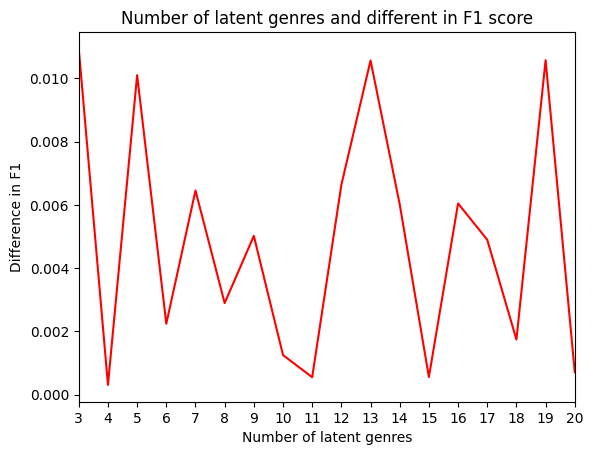

In [83]:
fig, ax = plt.subplots()
ax.plot(np.arange(3,21), np.abs(whole_m_lda_f1_ary - whole_f_lda_f1_ary), c='r', label='Difference in average F1 score with LDA')

# ax.hlines(y=np.average(all_f_cb_p), xmin=3, xmax=10, color='r', linestyle='--', label='Female average precision without LDA')

ax.set_xticks(np.arange(3,21))
# legend = ax.legend(loc='upper right')
ax.set_xlim([3,20])
# ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('Difference in F1')
plt.title('Number of latent genres and different in F1 score')
plt.show()

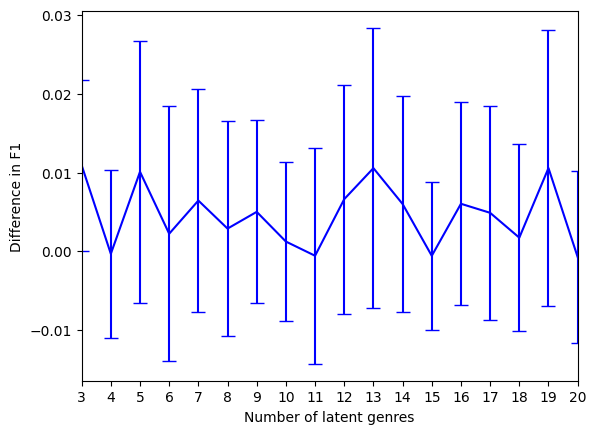

In [89]:
fig = plt.figure()
plt.errorbar(np.arange(3,21), whole_f_lda_f1_ary - whole_m_lda_f1_ary, yerr=whole_f_lda_f1_err_ary, capsize=5, c='b')
# plt.errorbar(np.arange(3,11), m_lda_r_list, yerr=m_lda_r_err_list, capsize=5, c='b', label='Male')
plt.xticks(np.arange(3,21))
plt.xlim([3,20])
# plt.ylim([0,0.03])
plt.xlabel('Number of latent genres')
plt.ylabel('Difference in F1')
plt.show()

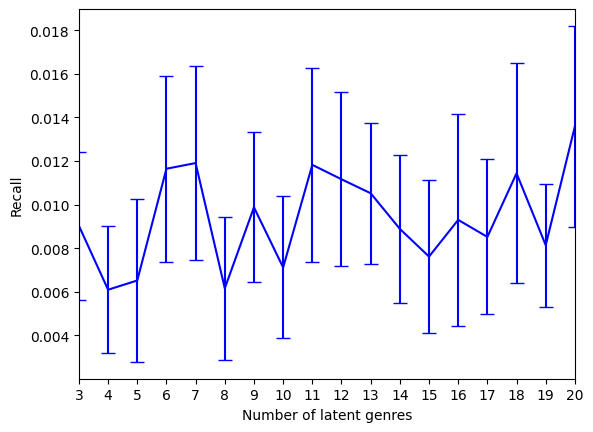

In [92]:
fig = plt.figure()
plt.errorbar(np.arange(3,21), whole_m_lda_r_ary, yerr=whole_m_lda_r_err_ary, capsize=5, c='b', label='Male')
# plt.errorbar(np.arange(3,11), m_lda_r_list, yerr=m_lda_r_err_list, capsize=5, c='b', label='Male')
plt.xticks(np.arange(3,21))
plt.xlim([3,20])
# plt.ylim([0,0.03])
plt.xlabel('Number of latent genres')
plt.ylabel('Recall')
plt.show()

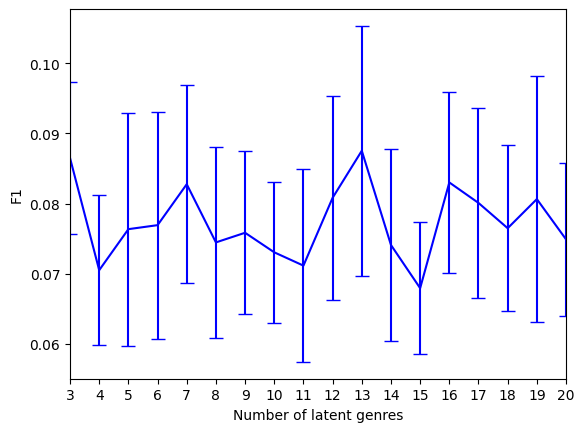

In [91]:
fig = plt.figure()
plt.errorbar(np.arange(3,21), whole_f_lda_f1_ary, yerr=whole_f_lda_f1_err_ary, capsize=5, c='b', label='Male')
# plt.errorbar(np.arange(3,11), m_lda_r_list, yerr=m_lda_r_err_list, capsize=5, c='b', label='Male')
plt.xticks(np.arange(3,21))
plt.xlim([3,20])
# plt.ylim([0,0.03])
plt.xlabel('Number of latent genres')
plt.ylabel('F1')
plt.show()

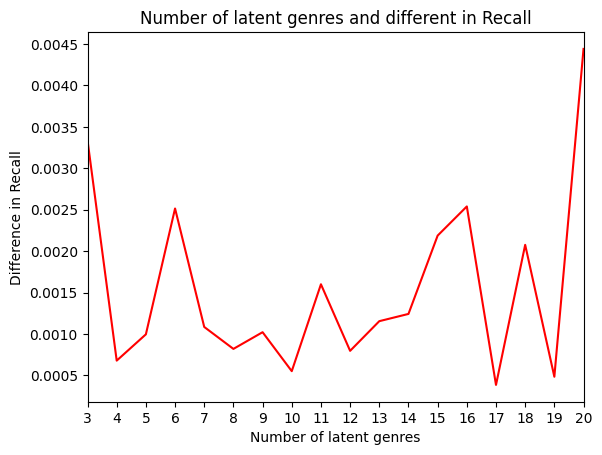

In [85]:
fig, ax = plt.subplots()
ax.plot(np.arange(3,21), np.abs(whole_m_lda_r_ary - whole_f_lda_r_ary), c='r', label='Difference in average recall with LDA')

# ax.hlines(y=np.average(all_f_cb_p), xmin=3, xmax=10, color='r', linestyle='--', label='Female average precision without LDA')

ax.set_xticks(np.arange(3,21))
# legend = ax.legend(loc='upper right')
ax.set_xlim([3,20])
# ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('Difference in Recall')
plt.title('Number of latent genres and different in Recall')
plt.show()

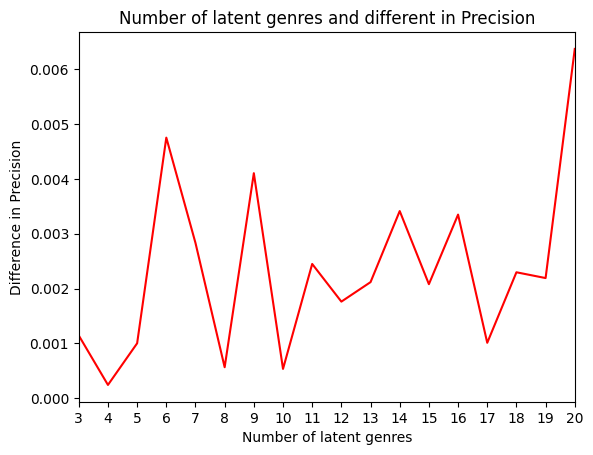

In [86]:
fig, ax = plt.subplots()
ax.plot(np.arange(3,21), np.abs(whole_m_lda_p_ary - whole_f_lda_p_ary), c='r', label='Difference in average precision with LDA')

# ax.hlines(y=np.average(all_f_cb_p), xmin=3, xmax=10, color='r', linestyle='--', label='Female average precision without LDA')

ax.set_xticks(np.arange(3,21))
# legend = ax.legend(loc='upper right')
ax.set_xlim([3,20])
# ax.set_ylim([0,0.03])
ax.set_xlabel('Number of latent genres')
ax.set_ylabel('Difference in Precision')
plt.title('Number of latent genres and different in Precision')
plt.show()